First of all, find all feature points in both images.
.

> Part of the code is from professor's tutorial.



In [ ]:
!pip install opencv-contrib-python==3.4.0.12
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import euclidean

# load two images
img1 = cv2.imread("./Book_cover.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("./Book_pic.png", cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp1_SIFT, desc1_SIFT = sift.detectAndCompute(img1, None)
kp2_SIFT, desc2_SIFT = sift.detectAndCompute(img2, None)

img1_SIFT = cv2.drawKeypoints(img1, kp1_SIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
img2_SIFT = cv2.drawKeypoints(img2, kp2_SIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))

kp1 = kp1_SIFT
kp2 = kp2_SIFT
desc1 = desc1_SIFT
desc2 = desc2_SIFT

# (brute force) matching of descriptors
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2) # k=2 means find the top two matchs for each query descriptor

# Apply ratio test (as per David Lowe's SIFT paper: compare the best match with the 2nd best match_
good_matches = []
good_matches_without_list = []
for m,n in matches:
    if m.distance < 0.75*n.distance: # only accept matchs that are considerably better than the 2nd best match
        good_matches.append([m])
        good_matches_without_list.append(m) # this is to simplify finding a homography later

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,
                          None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                          matchColor=(0,255,0))

Then apply the RANSAC

[[ 6.18943446e-02 -2.29986201e-01  4.32935045e+02]
 [ 2.29588580e-01  2.49362237e-02  1.37728674e+02]]


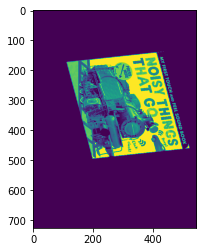

In [ ]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)
inliers_num = 0
best_m = None

#For part1, as calculated by the formular, to reach 99.5% chance based on 50% inliers, 
#we need to do at least 167 iterations.
# for _ in range(167):
#for part2, change the iteration to 250
for _ in range(250):
  #Find the random three points.
  three_index = random.sample(range(len(src_pts)), 3)
  src_three = np.float32([src_pts[three_index[0]][0], src_pts[three_index[1]][0], src_pts[three_index[2]][0]])
  dst_three = np.float32([dst_pts[three_index[0]][0], dst_pts[three_index[1]][0], dst_pts[three_index[2]][0]])
  #Then, get the affine transformation.
  M = cv2.getAffineTransform(src_three, dst_three)
  
  #then, find the number of inliers
  temp_inliers = 0
  for i in range(len(src_pts)):
    src = [src_pts[i][0][0], src_pts[i][0][1], 1]
    dst = dst_pts[i][0]

    trans_src = np.dot(M, src)
    distance = euclidean(trans_src, dst)
    if distance < 5:
      temp_inliers += 1
  
  #try to find whether this is a better matrix.
  if temp_inliers > inliers_num:
    inliers_num = temp_inliers
    best_m = M
print(best_m)
rows, cols = img2.shape
result = cv2.warpAffine(img1, best_m, (cols,rows))
plt.imshow(result)

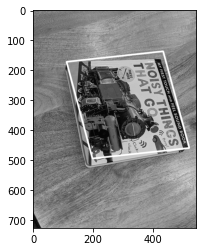

In [21]:
h,w = img1.shape
pts = [np.dot(best_m,[0,0,1]),np.dot(best_m,[0,h-1,1]),np.dot(best_m,[w-1,h-1,1]),np.dot(best_m,[w-1,0,1])]
img3 = cv2.polylines(img2,[np.int32(pts)],True,255,3, cv2.LINE_AA)
plt.imshow(img3, 'gray')

Here are the transformation with homography from the tutorial.

[[ 2.95911450e-02 -2.32316779e-01  4.23150658e+02]
 [ 1.77125388e-01 -7.73042631e-03  1.60741585e+02]
 [-7.57760467e-05 -8.86120337e-05  1.00000000e+00]]


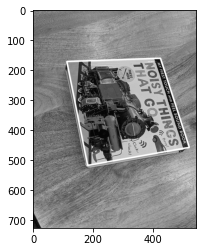

In [ ]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2) # k=2 means find the top two matchs for each query descriptor

# Apply ratio test (as per David Lowe's SIFT paper: compare the best match with the 2nd best match_
good_matches = []
good_matches_without_list = []
for m,n in matches:
    if m.distance < 0.75*n.distance: # only accept matchs that are considerably better than the 2nd best match
        good_matches.append([m])
        good_matches_without_list.append(m) # this is to simplify finding a homography later

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
print(M)
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
detected_book = cv2.perspectiveTransform(pts,M)
img3 = cv2.polylines(img2,[np.int32(detected_book)],True,255,3, cv2.LINE_AA)
plt.imshow(img3, 'gray')